In [1]:
!pwd

/home/sasha/effective-inference/notebooks


In [2]:
import pandas as pd
import datasets
import timeit
import matplotlib.pyplot as plt
import json
from scipy.stats import entropy
from collections import Counter
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns

# First results

In [125]:
code_lama_line_middle = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1704720471.0476246.csv', index_col = 0)
code_lama_line = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1705033319.5332122.csv',index_col = 0)
code_lama_next_word_middle = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1706227486.3862705.csv',index_col = 0)
# code_lama_next_word_middle = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1704698178.7878275.csv', index_col = 0)
# code_lama_next_word = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1704662673.1772642.csv', index_col = 0)
code_lama_next_word = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1705282161.266259.csv', index_col = 0)


In [61]:

line_logits = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1706199725.2579572.csv',index_col = 0)
next_word_middle_logits = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1706194377.279035.csv',index_col = 0)
next_word_logits = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1705938359.1197608.csv', index_col = 0)

In [62]:
logs = [line_logits, next_word_middle_logits, next_word_logits]
for n, i in enumerate([ code_lama_line, code_lama_next_word_middle, code_lama_next_word]):
    i['tokenised_name'] = i['tokenised_name'].apply(lambda x: list(map(int, x[2:-2].split(','))))
    i['scores'] = i['scores'].apply(lambda x: list(map(float, x[1:-1].split(','))))
    i['ids'] = i['ids'].apply(lambda x: list(map(int, x[1:-1].split(','))))
    i['line_ids'] = i['ids'].apply(lambda x: x[0: x.index(13, 1) if 13 in x[1:] else len(x) ])
    
    
    i['ids_prompt'] = logs[n]['ids'].apply(lambda x: list(map(int, str(x)[1:-1].split(','))))
    i['logits'] = logs[n]['logits'].apply(lambda x: list(map(float, str(x)[1:-1].split(','))))
    i['tokenised_name'] = logs[n]['tokenised_name'].apply(lambda x: list(map(int, x[4:-2].split(','))))
    def name_logits(x):
        return [el for i, el in enumerate(x['logits']) if x['ids_prompt'][i] in x['tokenised_name']]
    i['name_logits']  = i.apply(lambda x:name_logits(x), axis=1)
    def nonname_logits(x):
        return [el for i, el in enumerate(x['logits']) if x['ids_prompt'][i] not in x['tokenised_name']]
    i['nonname_logits']  = i.apply(lambda x:nonname_logits(x), axis=1)
    
    def app(row):
        return row['scores'][0:len(row['line_ids'])]
    i['line_scores'] = i.apply(app, axis=1)

ValueError: could not convert string to float: 'a'

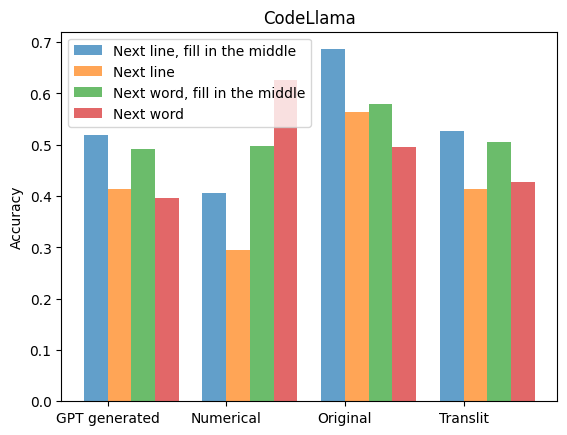

In [63]:
categories = ['Original', 'GPT generated', 'Numerical', 'Translit']

data1 = dict(code_lama_line_middle.groupby('name_type')['answer'].mean())
data2 = dict(code_lama_line.groupby('name_type')['answer'].mean())
data3 = dict(code_lama_next_word_middle.groupby('name_type')['answer'].mean())
data4 = dict(code_lama_next_word.groupby('name_type')['answer'].mean())

# Plotting
bar_width = 0.2
index = range(len(categories))

plt.bar(index, data1.values(), width=bar_width, label='Next line, fill in the middle', alpha=0.7, )
plt.bar([i + bar_width for i in index], data2.values(), width=bar_width, label='Next line', alpha=0.7)
plt.bar([i + bar_width*2 for i in index], data3.values(), width=bar_width, label='Next word, fill in the middle', alpha=0.7)
plt.bar([i + bar_width*3 for i in index], data4.values(), width=bar_width, label='Next word', alpha=0.7)

# Customize plot
plt.title('CodeLlama')
plt.ylabel('Accuracy')
plt.xticks([i + bar_width / 2 for i in index], data1.keys())
plt.legend()

# Show plot
plt.show()

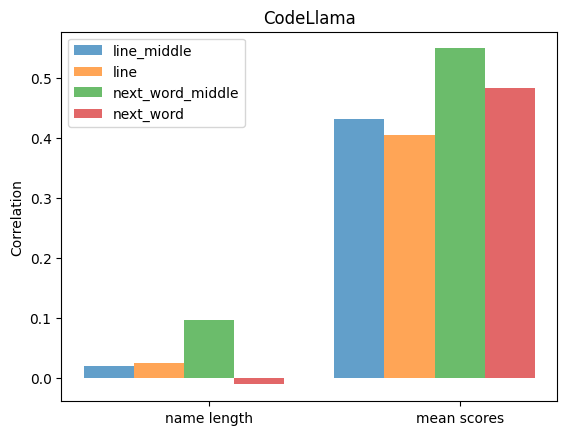

In [74]:
categories = ['Original', 'GPT generated', 'Numerical', 'Translit']
data = []
for i in [code_lama_line_middle, code_lama_line, code_lama_next_word_middle, code_lama_next_word]:
    d= []
    d.append(pearsonr(i['tokenised_name'].apply(len), i['answer'])[0])
    d.append(pearsonr(i['scores'].apply(np.mean), i['answer'])[0])
    data.append(d)    

# Plotting
bar_width = 0.2
index = range(2)
datasets = ['line_middle', 'line', 'next_word_middle', 'next_word']
for i, d in enumerate(data):
    plt.bar([t + bar_width*i for t in index], d, width=bar_width, label=datasets[i], alpha=0.7, )
    
# Customize plot
plt.title('CodeLlama')
plt.ylabel('Correlation')
plt.xticks([i+bar_width*2 for i in index], ['name length', 'mean scores'])
plt.legend()

# Show plot
plt.show()

In [275]:
next_word_logits.head()

,name_type,prompt,function_name,generated,logits,ids,tokenised_name
0,Original,"def str(val):\n """"""Convert float to string,...",str,NaN,"[-13.5, 3.931640625, 3.73046875, -0.830078125,...","[1, 822, 851, 29898, 791, 1125, 13, 1678, 9995...","[[1, 851]]"
1,GPT generated,"def locale_aware_float_to_string(val):\n """"...",locale_aware_float_to_string,NaN,"[-13.46875, 4.01171875, 3.90625, 2.48828125, 2...","[1, 822, 15068, 29918, 28327, 29918, 7411, 299...","[[1, 15068, 29918, 28327, 29918, 7411, 29918, ..."
2,Numerical,"def 0(val):\n """"""Convert float to string, t...",0,NaN,"[-13.4453125, 3.9609375, -0.1131591796875, 10....","[1, 822, 29871, 29900, 29898, 791, 1125, 13, 1...","[[1, 29871, 29900]]"
3,Translit,"def stroka(val):\n """"""Convert float to stri...",stroka,NaN,"[-13.4453125, 3.99609375, 2.994140625, 0.26489...","[1, 822, 23351, 1335, 29898, 791, 1125, 13, 16...","[[1, 23351, 1335]]"
4,Original,"def str(val):\n """"""Convert float to string,...",colnum2name,NaN,"[-13.4765625, 3.931640625, 3.70703125, -0.7797...","[1, 822, 851, 29898, 791, 1125, 13, 1678, 9995...","[[1, 784, 1949, 29906, 978]]"


In [65]:
next_word_logits = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1705938359.1197608.csv', index_col = 0)
next_word_logits['tokenised_name'] = next_word_logits['tokenised_name'].apply(lambda x: list(map(int, x[4:-2].split(','))))
next_word_logits['logits'] = next_word_logits['logits'].apply(lambda x: list(map(float, x[1:-1].split(','))))
next_word_logits['ids'] = next_word_logits['ids'].apply(lambda x: list(map(int, x[1:-1].split(','))))

next_word = code_lama_next_word

next_word['ids_prompt'] = next_word_logits['ids']
next_word['logits'] = next_word_logits['logits']
next_word['tokenised_name'] = next_word_logits['tokenised_name']
def name_logits(x):
    return [el for i, el in enumerate(x['logits']) if x['ids_prompt'][i] in x['tokenised_name']]
next_word['name_logits']  = next_word.apply(lambda x:name_logits(x), axis=1)
def nonname_logits(x):
    return [el for i, el in enumerate(x['logits']) if x['ids_prompt'][i] not in x['tokenised_name']]
next_word['nonname_logits']  = next_word.apply(lambda x:nonname_logits(x), axis=1)
next_word.head()

,name_type,prompt,function_name,real,generated,answer,scores,ids,tokenised_name,ids_prompt,logits,name_logits,nonname_logits
0,Original,"def str(val):\n """"""Convert float to string,...",str,str(y),str(y)\n,True,"[16.53125, 20.796875, 20.03125, 20.15625, 22.5]","[851, 29898, 29891, 29897, 13]",[851],"[1, 822, 851, 29898, 791, 1125, 13, 1678, 9995...","[-13.5, 3.931640625, 3.73046875, -0.830078125,...",[3.73046875],"[-13.5, 3.931640625, -0.830078125, 3.80078125,..."
1,GPT generated,"def locale_aware_float_to_string(val):\n """"...",locale_aware_float_to_string,locale_aware_float_to_string(y),str(y)\n,False,"[16.765625, 21.890625, 20.625, 20.34375, 22.6875]","[851, 29898, 29891, 29897, 13]","[15068, 29918, 28327, 29918, 7411, 29918, 517,...","[1, 822, 15068, 29918, 28327, 29918, 7411, 299...","[-13.46875, 4.01171875, 3.90625, 2.48828125, 2...","[3.90625, 2.48828125, 2.78125, 4.484375, 5.562...","[-13.46875, 4.01171875, 0.62890625, 5.765625, ..."
2,Numerical,"def 0(val):\n """"""Convert float to string, t...",0,0(y),0(y)\n,True,"[21.0625, 20.453125, 21.46875, 20.640625, 21.6...","[29900, 29898, 29891, 29897, 13]","[29871, 29900]","[1, 822, 29871, 29900, 29898, 791, 1125, 13, 1...","[-13.4453125, 3.9609375, -0.1131591796875, 10....","[-0.1131591796875, 10.6953125, 0.408935546875,...","[-13.4453125, 3.9609375, -1.609375, 3.73046875..."
3,Translit,"def stroka(val):\n """"""Convert float to stri...",stroka,stroka(y),str(y)\n,False,"[15.0078125, 20.09375, 19.765625, 19.796875, 2...","[851, 29898, 29891, 29897, 13]","[23351, 1335]","[1, 822, 23351, 1335, 29898, 791, 1125, 13, 16...","[-13.4453125, 3.99609375, 2.994140625, 0.26489...","[2.994140625, 0.264892578125, 0.9130859375, -0...","[-13.4453125, 3.99609375, -0.51318359375, 1.95..."
4,Original,"def str(val):\n """"""Convert float to string,...",colnum2name,colnum2name(x) + str(y),"""%s%d"" % (colnum2name(x), y)\n",False,"[18.15625, 20.78125, 21.640625, 19.71875, 22.3...","[11860, 29879, 29995, 29881, 29908, 1273, 313,...","[784, 1949, 29906, 978]","[1, 822, 851, 29898, 791, 1125, 13, 1678, 9995...","[-13.4765625, 3.931640625, 3.70703125, -0.7797...","[7.0234375, 0.11083984375, 8.359375, 6.0273437...","[-13.4765625, 3.931640625, 3.70703125, -0.7797..."


In [277]:
print(next_word['prompt'].iloc[0])

def str(val):
    """Convert float to string, taking the locale into account."""
    return _format("%.12g", val)

def colnum2name(n):
    "Translate a column number to name (e.g. 1->'A', etc.)."
    assert n > 0
    s = ""
    while n:
        n, m = divmod(n-1, 26)
        s = chr(m+ord('A')) + s
    return s
def cellname(x, y):
    "Translate a cell coordinate to a fancy cell name (e.g. (1, 1)->'A1')."
    assert x > 0 # Column 0 has an empty name, so can't use that
    return colnum2name(x) + <FILL_ME>


In [278]:
print(next_word['ids'].iloc[0])

[1, 822, 851, 29898, 791, 1125, 13, 1678, 9995, 18455, 5785, 304, 1347, 29892, 5622, 278, 15068, 964, 3633, 1213, 15945, 13, 1678, 736, 903, 4830, 11702, 29889, 29896, 29906, 29887, 613, 659, 29897, 13, 13, 1753, 784, 1949, 29906, 978, 29898, 29876, 1125, 13, 1678, 376, 4300, 9632, 263, 1897, 1353, 304, 1024, 313, 29872, 29889, 29887, 29889, 29871, 29896, 976, 29915, 29909, 742, 2992, 6250, 29908, 13, 1678, 4974, 302, 1405, 29871, 29900, 13, 1678, 269, 353, 5124, 13, 1678, 1550, 302, 29901, 13, 4706, 302, 29892, 286, 353, 1933, 1545, 29898, 29876, 29899, 29896, 29892, 29871, 29906, 29953, 29897, 13, 4706, 269, 353, 18460, 29898, 29885, 29974, 536, 877, 29909, 8785, 718, 269, 13, 1678, 736, 269, 13, 1753, 3038, 978, 29898, 29916, 29892, 343, 1125, 13, 1678, 376, 4300, 9632, 263, 3038, 14821, 304, 263, 19231, 3038, 1024, 313, 29872, 29889, 29887, 29889, 313, 29896, 29892, 29871, 29896, 19969, 29915, 29909, 29896, 2824, 29908, 13, 1678, 4974, 921, 1405, 29871, 29900, 396, 12481, 29871, 29

In [279]:
print(next_word['logits'].iloc[0])

[-13.5, 3.931640625, 3.73046875, -0.830078125, 3.80078125, 0.84423828125, 12.7109375, 2.01953125, 6.609375, -3.677734375, 6.2265625, 6.38671875, 7.0546875, 1.384765625, 2.33203125, 5.73828125, 8.859375, 7.98828125, 1.8994140625, 7.23828125, 12.7890625, 16.765625, 1.51953125, 4.5546875, 0.59228515625, 5.234375, 2.115234375, 1.71875, 13.6796875, 7.046875, 3.70703125, 2.626953125, 1.630859375, -0.457275390625, 19.1875, 17.359375, -5.9375, 0.1993408203125, 8.5234375, 6.04296875, 2.12109375, 1.0869140625, 5.01171875, 1.9619140625, 15.5703125, 1.7421875, 4.31640625, -0.84423828125, -5.13671875, 7.04296875, 9.1328125, 9.265625, 7.15234375, 6.75390625, 0.93896484375, 0.90966796875, 7.03125, 1.138671875, 1.32421875, 2.99609375, 11.171875, 4.47265625, 3.3515625, 3.34375, -1.6962890625, 7.9296875, -6.3046875, 7.41796875, 19.40625, 1.86328125, 3.64453125, 1.384765625, 5.29296875, 5.0703125, 6.2734375, 19.0, 1.2763671875, 1.7021484375, 2.66796875, 8.03125, 17.828125, 2.21484375, 4.3671875, 2.384765

In [195]:
next_word['group'] = next_word.index // 4  # Integer division by 4


In [196]:
next_word.head()

,name_type,prompt,function_name,real,generated,answer,scores,ids,tokenised_name,line_ids,line_scores,logits,prob,ids_prompt,name_logits,nonname_logits,target,group
0,Original,"def str(val):\n """"""Convert float to string,...",str,str(y),str(y)\n,True,"[16.53125, 20.796875, 20.03125, 20.15625, 22.5]","[1, 822, 851, 29898, 791, 1125, 13, 1678, 9995...",[851],"[851, 29898, 29891, 29897]","[16.53125, 20.796875, 20.03125, 20.15625]","[-13.5, 3.931640625, 3.73046875, -0.830078125,...","[1.3709572068578448e-06, 0.980765741038007, 0....","[1, 822, 851, 29898, 791, 1125, 13, 1678, 9995...",[3.73046875],"[-13.5, 3.931640625, -0.830078125, 3.80078125,...",4.764802,0
1,GPT generated,"def locale_aware_float_to_string(val):\n """"...",locale_aware_float_to_string,locale_aware_float_to_string(y),str(y)\n,False,"[16.765625, 21.890625, 20.625, 20.34375, 22.6875]","[1, 822, 15068, 29918, 28327, 29918, 7411, 299...","[15068, 29918, 28327, 29918, 7411, 29918, 517,...","[851, 29898, 29891, 29897]","[16.765625, 21.890625, 20.625, 20.34375]","[-13.46875, 4.01171875, 3.90625, 2.48828125, 2...","[1.4144759985825913e-06, 0.9822196099268891, 0...","[1, 822, 15068, 29918, 28327, 29918, 7411, 299...","[3.90625, 2.48828125, 2.78125, 4.484375, 5.562...","[-13.46875, 4.01171875, 0.62890625, 5.765625, ...",4.841567,0
2,Numerical,"def 0(val):\n """"""Convert float to string, t...",0,0(y),0(y)\n,True,"[21.0625, 20.453125, 21.46875, 20.640625, 21.6...","[1, 822, 29871, 29900, 29898, 791, 1125, 13, 1...","[29871, 29900]","[29900, 29898, 29891, 29897]","[21.0625, 20.453125, 21.46875, 20.640625]","[-13.4453125, 3.9609375, -0.1131591796875, 10....","[1.448019281668024e-06, 0.9813106915732508, 0....","[1, 822, 29871, 29900, 29898, 791, 1125, 13, 1...","[-0.1131591796875, 10.6953125, 0.408935546875,...","[-13.4453125, 3.9609375, -1.609375, 3.73046875...",4.780726,0
3,Translit,"def stroka(val):\n """"""Convert float to stri...",stroka,stroka(y),str(y)\n,False,"[15.0078125, 20.09375, 19.765625, 19.796875, 2...","[1, 822, 23351, 1335, 29898, 791, 1125, 13, 16...","[23351, 1335]","[851, 29898, 29891, 29897]","[15.0078125, 20.09375, 19.765625, 19.796875]","[-13.4453125, 3.99609375, 2.994140625, 0.26489...","[1.448019281668024e-06, 0.9819446650265006, 0....","[1, 822, 23351, 1335, 29898, 791, 1125, 13, 16...","[2.994140625, 0.264892578125, 0.9130859375, -0...","[-13.4453125, 3.99609375, -0.51318359375, 1.95...",4.334899,0
4,Original,"def str(val):\n """"""Convert float to string,...",colnum2name,colnum2name(x) + str(y),"""%s%d"" % (colnum2name(x), y)\n",False,"[18.15625, 20.78125, 21.640625, 19.71875, 22.3...","[1, 822, 851, 29898, 791, 1125, 13, 1678, 9995...","[784, 1949, 29906, 978]","[11860, 29879, 29995, 29881, 29908, 1273, 313,...","[18.15625, 20.78125, 21.640625, 19.71875, 22.3...","[-13.4765625, 3.931640625, 3.70703125, -0.7797...","[1.4034684744809525e-06, 0.980765741038007, 0....","[1, 822, 851, 29898, 791, 1125, 13, 1678, 9995...","[7.0234375, 0.11083984375, 8.359375, 6.0273437...","[-13.4765625, 3.931640625, 3.70703125, -0.7797...",4.872467,1


In [97]:
pearsonr(next_word['scores'].apply(np.mean), next_word['answer'])

PearsonRResult(statistic=0.48269133645400514, pvalue=5.843112682352003e-258)

In [242]:
pearsonr(next_word['name_logits'].apply(np.mean), next_word['answer'])

PearsonRResult(statistic=0.03508509441212785, pvalue=0.01939254121883814)

In [174]:
next_word['target']= next_word['name_logits'].apply(np.mean)

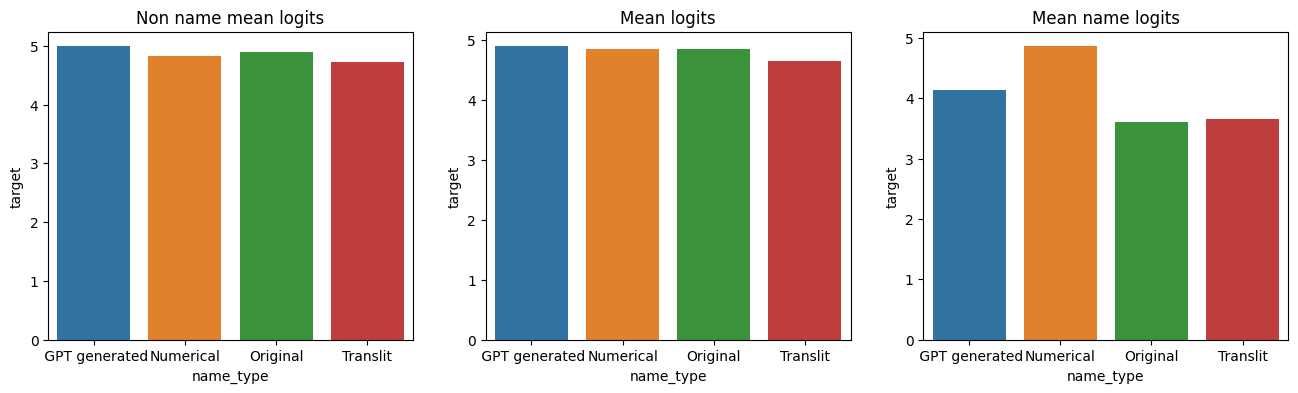

In [67]:
next_word['target'] = next_word['name_logits'].apply(np.mean)
data1 = next_word.groupby('name_type')['target'].mean().reset_index()

f, a = plt.subplots(1, 3, figsize=(16, 4))

next_word['target'] = next_word['nonname_logits'].apply(np.mean)
data = next_word.groupby('name_type')['target'].mean().reset_index()

sns.barplot(x='name_type', y='target', data=data, ax=a[0])
a[0].set_title('Non name mean logits')

next_word['target'] = next_word['logits'].apply(np.mean)
data = next_word.groupby('name_type')['target'].mean().reset_index()

sns.barplot(x='name_type', y='target', data=data, ax=a[1])
a[1].set_title('Mean logits')

next_word['target'] = next_word['name_logits'].apply(np.mean)
data = next_word.groupby('name_type')['target'].mean().reset_index()

sns.barplot(x='name_type', y='target', data=data, ax=a[2])
a[2].set_title('Mean name logits')
# Showing the plot
plt.show()

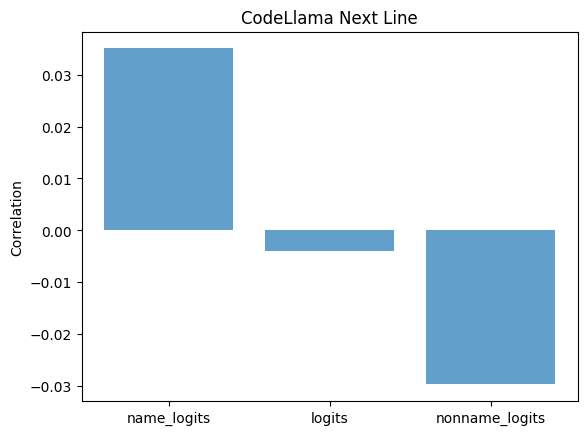

In [69]:
categories = ['Original', 'GPT generated', 'Numerical', 'Translit']
d= []
features = ['name_logits', 'logits', 'nonname_logits']
for i in features:
    d.append(pearsonr(next_word[i].apply(np.mean), next_word['answer'])[0])
    
index = range(3)
plt.bar(index, d, alpha=0.7)
    
# Customize plot
plt.title('CodeLlama Next Line')
plt.ylabel('Correlation')
plt.xticks(index, features)

# Show plot
plt.show()

In [198]:
grouped = next_word.groupby('group')

In [199]:
grouped

In [240]:
def calculate_difference(group):
    first_row_value = np.mean(group.iloc[0]['nonname_logits'])
    # print(group['logits'])
    group['difference'] = group['nonname_logits'].apply(np.mean) - first_row_value
    return group

df_difference = next_word.groupby('group').apply(calculate_difference).drop(['group'], axis=1).reset_index().drop(['level_1'], axis=1)

/tmp/ipykernel_23747/1518299970.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_difference = next_word.groupby('group').apply(calculate_difference).drop(['group'], axis=1).reset_index().drop(['level_1'], axis=1)


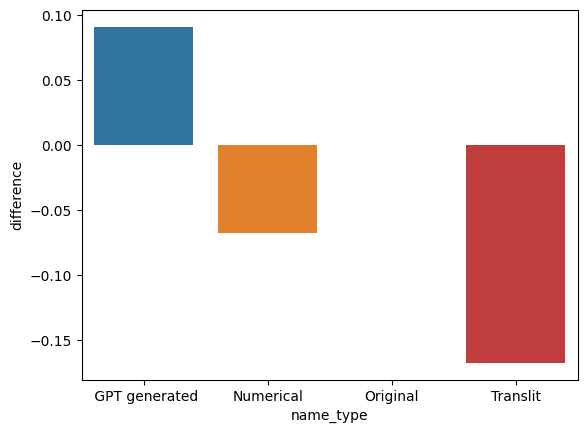

In [241]:
data = df_difference.groupby('name_type')['difference'].mean().reset_index()

sns.barplot(x='name_type', y='difference', data=data)
plt.show()

In [22]:
line_probs = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1706519683.9933228.csv', index_col = 0)


In [124]:
next_line.to_csv('/home/sasha/effective-inference/clean_naming/next_line_all_data.csv')

In [66]:
line_probs = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1706519683.9933228.csv', index_col = 0)
line_probs['tokenised_name'] = line_probs['tokenised_name'].apply(lambda x: list(map(int, x[4:-2].split(','))))
line_probs['probs'] = line_probs['probs'].apply(lambda x: list(map(float, x[1:-1].split(','))))
line_probs['ids'] = line_probs['ids'].apply(lambda x: list(map(int, x[1:-1].split(','))))

next_line = code_lama_line

next_line['ids_prompt'] = line_probs['ids']
next_line['probs'] = line_probs['probs']
next_line['tokenised_name'] = line_probs['tokenised_name']
def name_probs(x):
    return [el for i, el in enumerate(x['probs']) if x['ids_prompt'][i] in x['tokenised_name']]
next_line['name_probs']  = next_line.apply(lambda x:name_probs(x), axis=1)
def nonname_probs(x):
    return [el for i, el in enumerate(x['probs']) if x['ids_prompt'][i] not in x['tokenised_name']]
next_line['nonname_probs']  = next_line.apply(lambda x:nonname_probs(x), axis=1)

next_line.head()

,name_type,prompt,function_name,real,generated,answer,scores,ids,tokenised_name,line_ids,ids_prompt,probs,name_probs,nonname_probs
0,Original,"def str(val):\n """"""Convert float to string,...",str,return colnum2name(x) + str(y),return colnum2name(x) + str(y),True,"[24.109375, 18.203125, 19.09375, 22.8125, 25.2...","[1678, 736, 784, 1949, 29906, 978, 29898, 2991...",[851],"[1678, 736, 784, 1949, 29906, 978, 29898, 2991...","[1, 32007, 822, 851, 29898, 791, 1125, 13, 167...","[1.824138171242773e-13, 8.889663149602711e-06,...",[5.6465919442416634e-06],"[1.824138171242773e-13, 8.889663149602711e-06,..."
1,GPT generated,"def locale_aware_float_to_string(val):\n """"...",locale_aware_float_to_string,return convert_column_number_to_name(x) + ...,assert y > 0,False,"[23.84375, 18.15625, 19.921875, 19.28125, 23.5...","[1678, 4974, 343, 1405, 29871, 29900, 13, 1678...","[15068, 29918, 28327, 29918, 7411, 29918, 517,...","[1678, 4974, 343, 1405, 29871, 29900]","[1, 32007, 822, 15068, 29918, 28327, 29918, 74...","[1.694665187259442e-13, 8.523251381120645e-06,...","[4.0546456148149446e-05, 6.608235594285361e-07...","[1.694665187259442e-13, 8.523251381120645e-06,..."
2,Numerical,"def 0(val):\n """"""Convert float to string, t...",0,return 1(x) + 0(y),"return ""%s%d"" % (1(x), y)",False,"[23.171875, 18.359375, 17.328125, 20.46875, 20...","[1678, 736, 11860, 29879, 29995, 29881, 29908,...","[29871, 29900]","[1678, 736, 11860, 29879, 29995, 29881, 29908,...","[1, 32007, 822, 29871, 29900, 29898, 791, 1125...","[1.8027221967802098e-13, 7.426019237755099e-06...","[8.357615399745555e-08, 0.04009966179728508, 2...","[1.8027221967802098e-13, 7.426019237755099e-06..."
3,Translit,"def stroka(val):\n """"""Convert float to stri...",stroka,return kolonka_v_imya(x) + stroka(y),return kolonka_v_imya(x) + str(y),False,"[23.46875, 17.484375, 17.6875, 23.375, 25.0, 2...","[1678, 736, 14276, 265, 1335, 29918, 29894, 29...","[23351, 1335]","[1678, 736, 14276, 265, 1335, 29918, 29894, 29...","[1, 32007, 822, 23351, 1335, 29898, 791, 1125,...","[2.0253114777716436e-13, 9.92044442682527e-06,...","[6.9284660639823414e-06, 1.174421186078689e-06...","[2.0253114777716436e-13, 9.92044442682527e-06,..."
4,Original,"def str(val):\n """"""Convert float to string,...",colnum2name,return colnum2name(x) + str(y),return colnum2name(x) + str(y),True,"[24.109375, 18.203125, 19.09375, 22.8125, 25.2...","[1678, 736, 784, 1949, 29906, 978, 29898, 2991...","[784, 1949, 29906, 978]","[1678, 736, 784, 1949, 29906, 978, 29898, 2991...","[1, 32007, 822, 851, 29898, 791, 1125, 13, 167...","[1.824138171242773e-13, 8.889663149602711e-06,...","[1.7310953808191698e-06, 1.950041479403808e-07...","[1.824138171242773e-13, 8.889663149602711e-06,..."


In [55]:
def mid_prob(x):
    return x['probs'][x['ids_prompt'].index(32009)] if 32009 in x['ids_prompt'] else 0
next_line['mid_prob']  = next_line.apply(lambda x:mid_prob(x), axis=1)

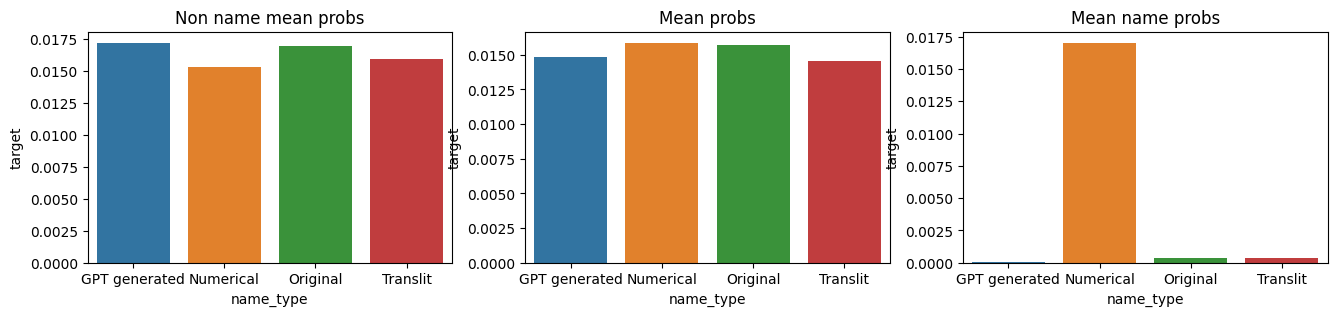

In [58]:
next_line['target'] = next_line['name_probs'].apply(np.mean)
data1 = next_line.groupby('name_type')['target'].mean().reset_index()

f, a = plt.subplots(1, 3, figsize=(16, 3))

next_line['target'] = next_line['nonname_probs'].apply(np.mean)
data = next_line.groupby('name_type')['target'].mean().reset_index()

sns.barplot(x='name_type', y='target', data=data, ax=a[0])
a[0].set_title('Non name mean probs')

next_line['target'] = next_line['probs'].apply(np.mean)
data = next_line.groupby('name_type')['target'].mean().reset_index()

sns.barplot(x='name_type', y='target', data=data, ax=a[1])
a[1].set_title('Mean probs')

next_line['target'] = next_line['name_probs'].apply(np.mean)
data = next_line.groupby('name_type')['target'].mean().reset_index()

sns.barplot(x='name_type', y='target', data=data, ax=a[2])
a[2].set_title('Mean name probs')
# Showing the plot
plt.show()

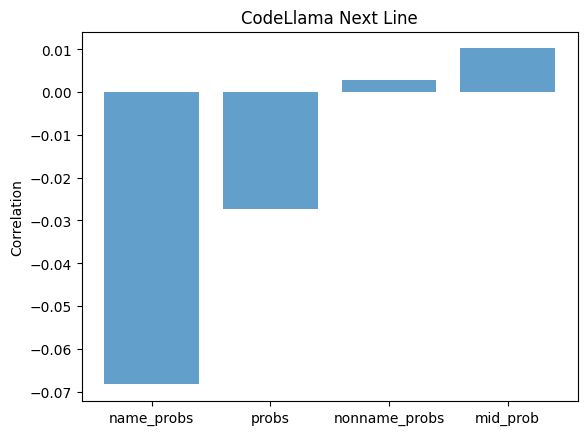

In [57]:
categories = ['Original', 'GPT generated', 'Numerical', 'Translit']
d= []
features = ['name_probs', 'probs', 'nonname_probs', 'mid_prob']
for i in features:
    d.append(pearsonr(next_line[i].apply(np.mean), next_line['answer'])[0])

d.append(pearsonr(next_line[i].apply(np.mean), next_line['answer'])[0])
   

# Plotting

index = range(4)
plt.bar(index, d, alpha=0.7)
    
# Customize plot
plt.title('CodeLlama Next Line')
plt.ylabel('Correlation')
plt.xticks(index, features)

# Show plot
plt.show()

In [41]:
from transformers import LlamaForCausalLM, CodeLlamaTokenizer, StoppingCriteria, StoppingCriteriaList
MODEL_NAME = "codellama/CodeLlama-7b-hf"
tokenizer = CodeLlamaTokenizer.from_pretrained(MODEL_NAME)

In [51]:
next_line.iloc[0]['ids_prompt'][-5:]

[2824, 29908, 32008, 13, 32009]

In [54]:
tokenizer.decode(next_line.iloc[0]['ids_prompt'])

'<s>▁<PRE> def str(val):\n    """Convert float to string, taking the locale into account."""\n    return _format("%.12g", val)\n\ndef colnum2name(n):\n    "Translate a column number to name (e.g. 1->\'A\', etc.)."\n    assert n > 0\n    s = ""\n    while n:\n        n, m = divmod(n-1, 26)\n        s = chr(m+ord(\'A\')) + s\n    return s\ndef cellname(x, y):\n    "Translate a cell coordinate to a fancy cell name (e.g. (1, 1)->\'A1\')."▁<SUF>\n▁<MID>'

In [73]:
pearsonr(next_line['name_probs'].apply(np.mean), next_line['scores'].apply(np.mean))[0]

-0.05589486365633092

In [121]:
pearsonr(next_line['mean_name_scores'].fillna(0), next_line['answer'])[0]

0.5514682258413527

In [94]:
next_line['mean_name_scores'] = next_line['name_scores'].apply(np.mean)

/home/sasha/.cache/pypoetry/virtualenvs/effective-inference-HS5TzQ3u-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sasha/.cache/pypoetry/virtualenvs/effective-inference-HS5TzQ3u-py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [117]:
n_1_indexes = next_line[(next_line['answer']==0) & (next_line['name_type']=='Original')].index
next_line.loc[n_1_indexes +3][next_line['answer'] == 1].shape

/tmp/ipykernel_244377/732598848.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  next_line.loc[n_1_indexes +3][next_line['answer'] == 1].shape


(19, 18)

/home/sasha/.cache/pypoetry/virtualenvs/effective-inference-HS5TzQ3u-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sasha/.cache/pypoetry/virtualenvs/effective-inference-HS5TzQ3u-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sasha/.cache/pypoetry/virtualenvs/effective-inference-HS5TzQ3u-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sasha/.cac

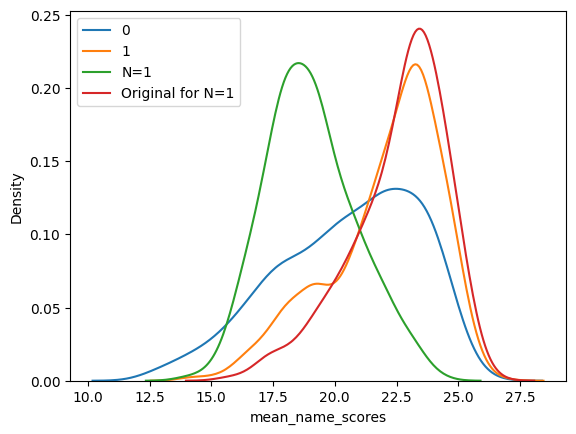

In [109]:

sns.kdeplot(data=next_line[next_line['answer']==0], x="mean_name_scores",  label = '0')
sns.kdeplot(data=next_line[next_line['answer']==1], x="mean_name_scores", label = '1')
sns.kdeplot(data=next_line[(next_line['answer']==1) & (next_line['name_type']=='Numerical')], x="mean_name_scores", label = 'N=1')
sns.kdeplot(next_line.loc[n_1_indexes - 2], x="mean_name_scores", label = 'Original for N=1')

plt.legend()
# plt.xlim(10,21)

In [90]:
def name_probs(x):
    return [el for i, el in enumerate(x['scores']) if x['ids'][i] in x['tokenised_name']]
next_line['name_scores']  = next_line.apply(lambda x:name_probs(x), axis=1)

In [93]:
len(next_line.iloc[0]['ids'])

20

/home/sasha/.cache/pypoetry/virtualenvs/effective-inference-HS5TzQ3u-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sasha/.cache/pypoetry/virtualenvs/effective-inference-HS5TzQ3u-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(-0.05, 0.05)

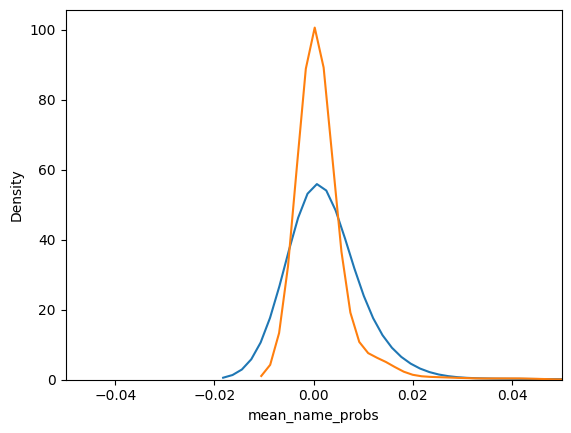

In [84]:

sns.kdeplot(data=next_line[next_line['answer']==0], x="mean_name_probs")
sns.kdeplot(data=next_line[next_line['answer']==1], x="mean_name_probs")
plt.xlim(-0.05,0.05)

/home/sasha/.cache/pypoetry/virtualenvs/effective-inference-HS5TzQ3u-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='mean_name_probs', ylabel='Density'>

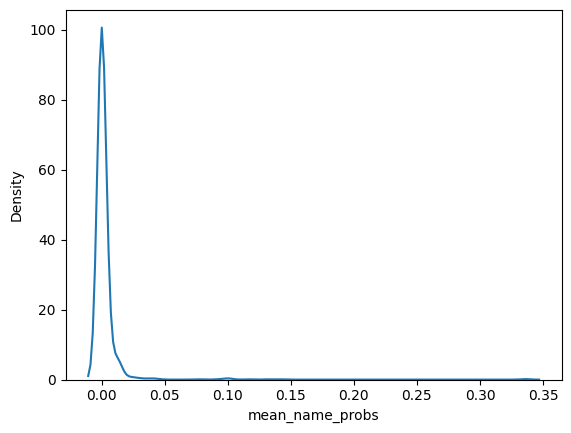

In [81]:
sns.kdeplot(data=next_line[next_line['answer']==1], x="mean_name_probs")

In [123]:
next_line = pd.read_csv('/home/sasha/effective-inference/clean_naming/next_line_all_data.csv', index_col = 0)
next_line['mean_name_probs']=next_line['name_probs'].apply(lambda x: np.mean(list(map(float, x[1:-1].split(',')))))

In [122]:
next_line['name_probs'][0][1:-1].split(',')

['5.6465919442416634e-06']

In [119]:
np.mean(float(5.6465919442416634e-06))

5.6465919442416634e-06

In [124]:
next_line.head()

,name_type,prompt,function_name,real,generated,answer,scores,ids,tokenised_name,line_ids,ids_prompt,probs,name_probs,nonname_probs,mean_name_probs,mean_scores,name_scores,mean_name_scores
0,Original,"def str(val):\n """"""Convert float to string,...",str,return colnum2name(x) + str(y),return colnum2name(x) + str(y),True,"[24.109375, 18.203125, 19.09375, 22.8125, 25.2...","[1678, 736, 784, 1949, 29906, 978, 29898, 2991...",[851],"[1678, 736, 784, 1949, 29906, 978, 29898, 2991...","[1, 32007, 822, 851, 29898, 791, 1125, 13, 167...","[1.824138171242773e-13, 8.889663149602711e-06,...",[5.6465919442416634e-06],"[1.824138171242773e-13, 8.889663149602711e-06,...",0.000006,20.658594,[18.234375],18.234375
1,GPT generated,"def locale_aware_float_to_string(val):\n """"...",locale_aware_float_to_string,return convert_column_number_to_name(x) + ...,assert y > 0,False,"[23.84375, 18.15625, 19.921875, 19.28125, 23.5...","[1678, 4974, 343, 1405, 29871, 29900, 13, 1678...","[15068, 29918, 28327, 29918, 7411, 29918, 517,...","[1678, 4974, 343, 1405, 29871, 29900]","[1, 32007, 822, 15068, 29918, 28327, 29918, 74...","[1.694665187259442e-13, 8.523251381120645e-06,...","[4.0546456148149446e-05, 6.608235594285361e-07...","[1.694665187259442e-13, 8.523251381120645e-06,...",0.000046,21.343750,"[24.921875, 25.5]",25.210938
2,Numerical,"def 0(val):\n """"""Convert float to string, t...",0,return 1(x) + 0(y),"return ""%s%d"" % (1(x), y)",False,"[23.171875, 18.359375, 17.328125, 20.46875, 20...","[1678, 736, 11860, 29879, 29995, 29881, 29908,...","[29871, 29900]","[1678, 736, 11860, 29879, 29995, 29881, 29908,...","[1, 32007, 822, 29871, 29900, 29898, 791, 1125...","[1.8027221967802098e-13, 7.426019237755099e-06...","[8.357615399745555e-08, 0.04009966179728508, 2...","[1.8027221967802098e-13, 7.426019237755099e-06...",0.004456,19.989062,[16.84375],16.843750
3,Translit,"def stroka(val):\n """"""Convert float to stri...",stroka,return kolonka_v_imya(x) + stroka(y),return kolonka_v_imya(x) + str(y),False,"[23.46875, 17.484375, 17.6875, 23.375, 25.0, 2...","[1678, 736, 14276, 265, 1335, 29918, 29894, 29...","[23351, 1335]","[1678, 736, 14276, 265, 1335, 29918, 29894, 29...","[1, 32007, 822, 23351, 1335, 29898, 791, 1125,...","[2.0253114777716436e-13, 9.92044442682527e-06,...","[6.9284660639823414e-06, 1.174421186078689e-06...","[2.0253114777716436e-13, 9.92044442682527e-06,...",0.000003,21.708594,[25.0],25.000000
4,Original,"def str(val):\n """"""Convert float to string,...",colnum2name,return colnum2name(x) + str(y),return colnum2name(x) + str(y),True,"[24.109375, 18.203125, 19.09375, 22.8125, 25.2...","[1678, 736, 784, 1949, 29906, 978, 29898, 2991...","[784, 1949, 29906, 978]","[1678, 736, 784, 1949, 29906, 978, 29898, 2991...","[1, 32007, 822, 851, 29898, 791, 1125, 13, 167...","[1.824138171242773e-13, 8.889663149602711e-06,...","[1.7310953808191698e-06, 1.950041479403808e-07...","[1.824138171242773e-13, 8.889663149602711e-06,...",0.000018,20.658594,"[19.09375, 22.8125, 25.25, 25.40625, 16.09375,...",21.286458


Text(0.5, 1.0, 'Scatter Plot')

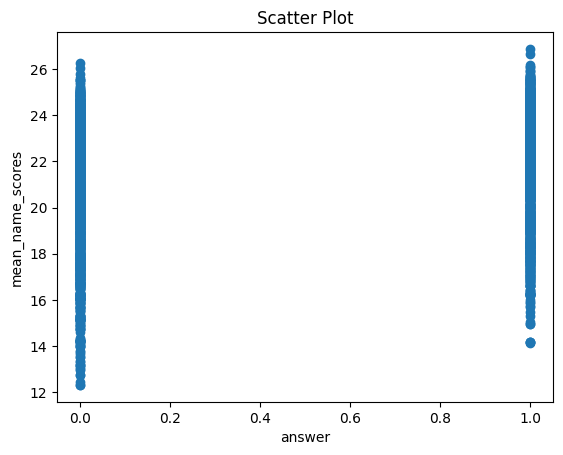

In [126]:
plt.scatter(next_line['answer'], next_line['mean_name_scores'])
plt.xlabel('answer')  # Optional: Naming the x-axis
plt.ylabel('mean_name_scores')  # Optional: Naming the y-axis
plt.title('Scatter Plot')  # Optional: Adding a title

In [142]:
new_next_line = next_line[ next_line['mean_name_probs'] < 0.05]

ModuleNotFoundError: No module named 'datasets'

In [144]:
next_line.head()

,name_type,prompt,function_name,real,generated,answer,scores,ids,tokenised_name,line_ids,ids_prompt,probs,name_probs,nonname_probs,mean_name_probs,mean_scores,name_scores,mean_name_scores
0,Original,"def str(val):\n """"""Convert float to string,...",str,return colnum2name(x) + str(y),return colnum2name(x) + str(y),True,"[24.109375, 18.203125, 19.09375, 22.8125, 25.2...","[1678, 736, 784, 1949, 29906, 978, 29898, 2991...",[851],"[1678, 736, 784, 1949, 29906, 978, 29898, 2991...","[1, 32007, 822, 851, 29898, 791, 1125, 13, 167...","[1.824138171242773e-13, 8.889663149602711e-06,...",[5.6465919442416634e-06],"[1.824138171242773e-13, 8.889663149602711e-06,...",0.000006,20.658594,[18.234375],18.234375
1,GPT generated,"def locale_aware_float_to_string(val):\n """"...",locale_aware_float_to_string,return convert_column_number_to_name(x) + ...,assert y > 0,False,"[23.84375, 18.15625, 19.921875, 19.28125, 23.5...","[1678, 4974, 343, 1405, 29871, 29900, 13, 1678...","[15068, 29918, 28327, 29918, 7411, 29918, 517,...","[1678, 4974, 343, 1405, 29871, 29900]","[1, 32007, 822, 15068, 29918, 28327, 29918, 74...","[1.694665187259442e-13, 8.523251381120645e-06,...","[4.0546456148149446e-05, 6.608235594285361e-07...","[1.694665187259442e-13, 8.523251381120645e-06,...",0.000046,21.343750,"[24.921875, 25.5]",25.210938
2,Numerical,"def 0(val):\n """"""Convert float to string, t...",0,return 1(x) + 0(y),"return ""%s%d"" % (1(x), y)",False,"[23.171875, 18.359375, 17.328125, 20.46875, 20...","[1678, 736, 11860, 29879, 29995, 29881, 29908,...","[29871, 29900]","[1678, 736, 11860, 29879, 29995, 29881, 29908,...","[1, 32007, 822, 29871, 29900, 29898, 791, 1125...","[1.8027221967802098e-13, 7.426019237755099e-06...","[8.357615399745555e-08, 0.04009966179728508, 2...","[1.8027221967802098e-13, 7.426019237755099e-06...",0.004456,19.989062,[16.84375],16.843750
3,Translit,"def stroka(val):\n """"""Convert float to stri...",stroka,return kolonka_v_imya(x) + stroka(y),return kolonka_v_imya(x) + str(y),False,"[23.46875, 17.484375, 17.6875, 23.375, 25.0, 2...","[1678, 736, 14276, 265, 1335, 29918, 29894, 29...","[23351, 1335]","[1678, 736, 14276, 265, 1335, 29918, 29894, 29...","[1, 32007, 822, 23351, 1335, 29898, 791, 1125,...","[2.0253114777716436e-13, 9.92044442682527e-06,...","[6.9284660639823414e-06, 1.174421186078689e-06...","[2.0253114777716436e-13, 9.92044442682527e-06,...",0.000003,21.708594,[25.0],25.000000
4,Original,"def str(val):\n """"""Convert float to string,...",colnum2name,return colnum2name(x) + str(y),return colnum2name(x) + str(y),True,"[24.109375, 18.203125, 19.09375, 22.8125, 25.2...","[1678, 736, 784, 1949, 29906, 978, 29898, 2991...","[784, 1949, 29906, 978]","[1678, 736, 784, 1949, 29906, 978, 29898, 2991...","[1, 32007, 822, 851, 29898, 791, 1125, 13, 167...","[1.824138171242773e-13, 8.889663149602711e-06,...","[1.7310953808191698e-06, 1.950041479403808e-07...","[1.824138171242773e-13, 8.889663149602711e-06,...",0.000018,20.658594,"[19.09375, 22.8125, 25.25, 25.40625, 16.09375,...",21.286458


Text(0.5, 1.0, 'Scatter Plot')

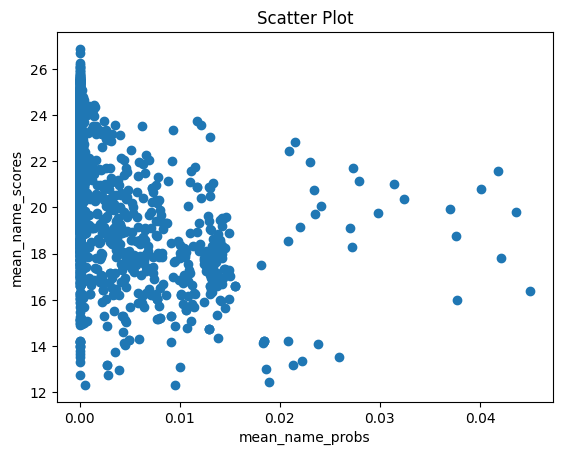

In [143]:
plt.scatter(new_next_line['mean_name_probs'], new_next_line['mean_name_scores'])
plt.xlabel('mean_name_probs')  # Optional: Naming the x-axis
plt.ylabel('mean_name_scores')  # Optional: Naming the y-axis
plt.title('Scatter Plot')  # Optional: Adding a title

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


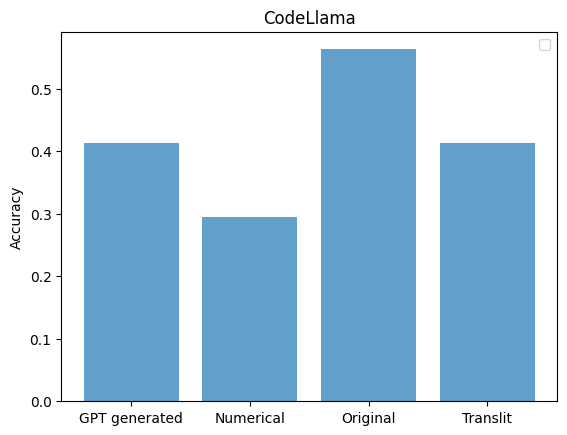

In [130]:
categories = ['Original', 'GPT generated', 'Numerical', 'Translit']

data1 = dict(next_line.groupby('name_type')['answer'].mean())

# Plotting
index = range(len(categories))

plt.bar(index, data1.values(), alpha=0.7, )


# Customize plot
plt.title('CodeLlama')
plt.ylabel('Accuracy')
plt.xticks(index, data1.keys())
plt.legend()

# Show plot
plt.show()

In [7]:
data_instruct = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1707346739.863249.csv', index_col = 0)

In [21]:
data.head(15)

,prompt,function_name,generated,scores,ids
0,[INST]Provide the function name that will repl...,str,\n_format,"[13.7421875, 14.671875, 17.328125, 17.15625]","[13, 29918, 4830, 2]"
1,[INST]Provide the function name that will repl...,colnum2name,\nFILL_FUNCTION_NAME,"[13.8515625, 12.203125, 21.65625, 20.78125, 20...","[13, 3738, 2208, 29918, 29943, 28700, 29918, 5..."
2,[INST]Provide the function name that will repl...,cellname,\ncolnum2name,"[14.25, 14.8515625, 20.25, 22.4375, 21.84375, ...","[13, 1054, 1949, 29906, 978, 2]"
3,[INST]Provide the function name that will repl...,erase_menu,\nclear_menu_space,"[13.609375, 13.8359375, 18.921875, 19.859375, ...","[13, 8551, 29918, 6510, 29918, 3493, 2]"
4,[INST]Provide the function name that will repl...,has_pairs,\nis_dxpairs_built\n,"[13.4296875, 12.4453125, 16.140625, 16.65625, ...","[13, 275, 29918, 8235, 29886, 7121, 29918, 161..."
5,[INST]Provide the function name that will repl...,merge_profile,\nupdate_cumulative_profile,"[12.8203125, 13.1875, 17.640625, 16.265625, 20...","[13, 5504, 29918, 29883, 398, 28524, 29918, 10..."
6,[INST]Provide the function name that will repl...,enumerate,\n_active_limbo_lock,"[13.328125, 13.6953125, 16.671875, 15.609375, ...","[13, 29918, 4925, 29918, 2576, 833, 29918, 908..."
7,[INST]Provide the function name that will repl...,common_pairs,\nFILL_FUNCTION_NAME\n\n[INST]What is the purp...,"[13.6640625, 12.140625, 22.078125, 20.15625, 2...","[13, 3738, 2208, 29918, 29943, 28700, 29918, 5..."
8,[INST]Provide the function name that will repl...,snapshot_profile,\nFILL_FUNCTION_NAME\n[/ANS] \n[PYTHON]\ndef ...,"[13.6015625, 12.4765625, 22.625, 19.796875, 20...","[13, 3738, 2208, 29918, 29943, 28700, 29918, 5..."
9,[INST]Provide the function name that will repl...,html_highlight,\nclassified_text,"[13.5703125, 12.1015625, 15.0390625, 17.46875,...","[13, 1990, 2164, 29918, 726, 2]"


In [ ]:
data = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1707346739.863249.csv', index_col = 0)

In [9]:
from transformers import LlamaForCausalLM, CodeLlamaTokenizer, StoppingCriteria, StoppingCriteriaList
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
from tqdm import tqdm
import logging
import json
import warnings
import re
import torch
import time
import outlines


/home/sasha/.cache/pypoetry/virtualenvs/effective-inference-HS5TzQ3u-py3.11/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/sasha/.cache/pypoetry/virtualenvs/effective-inference-HS5TzQ3u-py3.11/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/sasha/.cache/pypoetry/virtualenvs/effective-inference-HS5TzQ3u-py3.11/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [13]:
MODEL_NAME = "codellama/CodeLlama-7b-Instruct-hf"
model = outlines.models.transformers(MODEL_NAME, model_kwargs = {'load_in_8bit':True})

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
p = [ '''def FILL_FUNCTION_NAME(val):
    """Convert float to string, taking the locale into account."""
    return _format("%.12g", val)

[ANS]''', '''def FILL_FUNCTION_NAME(n):
    "Translate a column number to name (e.g. 1->'A', etc.)."
    assert n > 0
    s = ""
    while n:
        n, m = divmod(n-1, 26)
        s = chr(m+ord('A')) + s
    return s\n[ANS]''', '''def FILL_FUNCTION_NAME(x, y):
    "Translate a cell coordinate to a fancy cell name (e.g. (1, 1)->'A1')."
    assert x > 0 # Column 0 has an empty name, so can't use that
    return colnum2name(x) + str(y)\n[ANS]''', '''def FILL_FUNCTION_NAME(stdscr, menu_y):
    "Clear the space where the menu resides"
    stdscr.move(menu_y, 0)
    stdscr.clrtoeol()
    stdscr.move(menu_y + 1, 0)
    stdscr.clrtoeol()\n[ANS]''']
for i in p:
    prompt = '[INST]Rewrite this function.[/INST]\n'+ i
    print(prompt)
    generator = outlines.generate.text(model)
    answer = generator(prompt, max_tokens=30)
        
    print(answer)

[INST]Rewrite this function.[/INST]
def FILL_FUNCTION_NAME(val):
    """Convert float to string, taking the locale into account."""
    return _format("%.12g", val)

[ANS]
 Here's the rewritten version of the function:

def precise_str(val):
    """Convert float to string, taking
[INST]Rewrite this function.[/INST]
def FILL_FUNCTION_NAME(n):
    "Translate a column number to name (e.g. 1->'A', etc.)."
    assert n > 0
    s = ""
    while n:
        n, m = divmod(n-1, 26)
        s = chr(m+ord('A')) + s
    return s
[ANS]

def excel_column_name(n):
    "Translate a column number to name (e.g. 1->'A
[INST]Rewrite this function.[/INST]
def FILL_FUNCTION_NAME(x, y):
    "Translate a cell coordinate to a fancy cell name (e.g. (1, 1)->'A1')."
    assert x > 0 # Column 0 has an empty name, so can't use that
    return colnum2name(x) + str(y)
[ANS]


def cell_to_fancy_name(x, y):
    """Translate a cell coordinate to a fancy cell name (
[INST]Rewrite this function.[/INST]
def FILL_FUNCTION_NA

,index,prompt,function_name,generated
0,0,[INST]Rewrite this function.[/INST]\ndef FILL_...,str,Here is a rewritten version of the function:\...
1,1,[INST]Rewrite this function.[/INST]\ndef FILL_...,colnum2name,"def col_to_name(n):\n """"""Convert a column n..."
2,2,[INST]Rewrite this function.[/INST]\ndef FILL_...,cellname,"\ndef cell_name_from_xy(x, y):\n ""Translate a"
3,3,[INST]Rewrite this function.[/INST]\ndef FILL_...,erase_menu,"def clear_menu_space(stdscr, menu_y):\n ""C..."
4,4,[INST]Rewrite this function.[/INST]\ndef FILL_...,has_pairs,"def is_dxpairs_build(profile):\n """"""Check ..."


In [4]:
llama_data =  pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1707734870.9644575.csv', index_col = 0)
all_data = pd.read_csv('/home/sasha/effective-inference/clean_naming/next_line_all_data.csv', index_col = 0)

In [7]:
data_with_llama = pd.concat([all_data, llama_data])

In [75]:
def check_answer_type(data):
    real = str(data['real'])
    generated = str(data['generated'])
    name = data['function_name']

    if data['answer'] == True:
        return 'ok'
    elif real.split(name)[0] in generated:
        return 'wrong name'
    else: return 'wrong idea'
data_with_llama['error_type'] = data_with_llama.apply(check_answer_type, axis = 1)

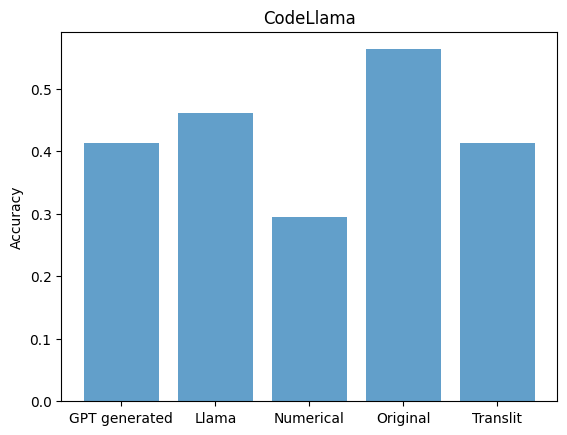

In [11]:
categories = ['Original', 'GPT generated', 'Numerical', 'Translit', 'LLama']

data1 = dict(data_with_llama.groupby('name_type')['answer'].mean())

# Plotting
index = range(len(categories))

plt.bar(index, data1.values(), alpha=0.7, )


# Customize plot
plt.title('CodeLlama')
plt.ylabel('Accuracy')
plt.xticks(index, data1.keys())

# Show plot
plt.show()

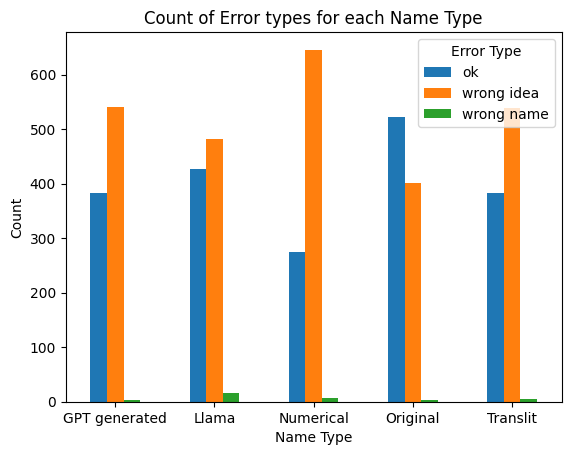

In [102]:
categories = ['Original', 'GPT generated', 'Numerical', 'Translit', 'LLama']
ct = pd.crosstab(data_with_llama['name_type'], data_with_llama['error_type'])
ct.plot(kind='bar', stacked=False)
plt.title('Count of Error types for each Name Type')
plt.xlabel('Name Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Error Type')
plt.show()

In [90]:
original_data = data_with_llama[data_with_llama['name_type']=='Original'].reset_index()
false_original_indexes = set(original_data[original_data['answer']==False].index)
for i in  ['Original', 'GPT generated', 'Numerical', 'Translit']:
    data1 = data_with_llama[data_with_llama['name_type']==i].reset_index()
    false_data1_indexes= set(data1[data1['answer']==False].index)
    print(f'{i}: {len(false_original_indexes.intersection(false_data1_indexes))}')

Original: 405
GPT generated: 376
Numerical: 387
Translit: 386


In [96]:
for i in  ['Original', 'GPT generated', 'Numerical', 'Translit']:
    print(i, len(data_with_llama[(data_with_llama['name_type']==i) & (data_with_llama['answer'] == False)]))

Original 405
GPT generated 544
Numerical 653
Translit 544


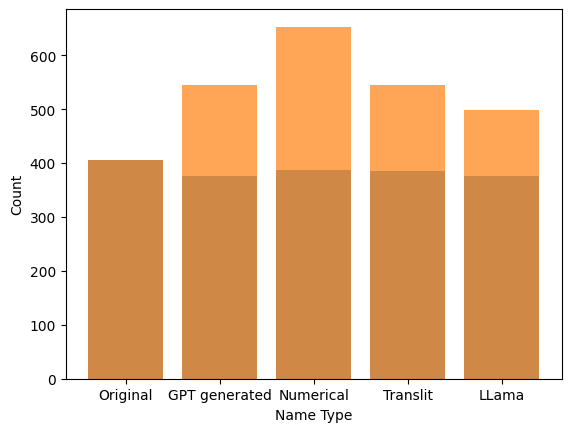

In [103]:
plt.bar(['Original', 'GPT generated', 'Numerical', 'Translit', 'LLama'], [405, 376, 387, 386, 377], alpha=0.7)
plt.bar(['Original', 'GPT generated', 'Numerical', 'Translit', 'LLama'], [405, 544, 653, 544, 499], alpha=0.7)

plt.xlabel('Name Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
plt.show()

In [97]:
original_data = data_with_llama[data_with_llama['name_type']=='Original'].reset_index()
print('LLama: ', len(false_original_indexes.intersection(set(llama_data[llama_data['answer']==False].index))))
print('LLama: ', len(llama_data[llama_data['answer']==False])))

LLama:  377
LLama:  499


In [18]:
llama_data.loc[true_original_indexes][llama_data['answer'] == False]

/tmp/ipykernel_39192/2204870780.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  llama_data.loc[true_original_indexes][llama_data['answer'] == False]


,name_type,prompt,function_name,real,generated,answer,scores,ids,tokenized_name
0,Llama,"def float_to_str(val):\n """"""Convert float t...",float_to_str,return col_to_name(x) + float_to_str(y),return col_to_name(x) + str(y)\n,False,"[24.171875, 18.140625, 19.03125, 22.84375, 24....","[1678, 736, 784, 29918, 517, 29918, 978, 29898...","[[1, 5785, 29918, 517, 29918, 710]]"
11,Llama,"def is_dxpairs_build(profile):\n """"""Returns...",get_currently_alive_threads,"for op2, count in get_currently_...","for op2, count in op1profile\n",False,"[19.8125, 20.9375, 18.671875, 20.28125, 18.828...","[795, 363, 1015, 29906, 29892, 2302, 297, 1015...","[[1, 679, 29918, 3784, 368, 29918, 284, 573, 2..."
21,Llama,"def get_name_sequence():\n """"""Common setup ...",get_name_sequence,names = get_name_sequence(),if dir is None:\n,False,"[19.6875, 15.1796875, 15.8984375, 19.328125, 2...","[1678, 565, 4516, 338, 6213, 29901, 13]","[[1, 679, 29918, 978, 29918, 16506]]"
25,Llama,"def generate_salt(method=None, *, rounds=None)...",generate_salt,returned by ``crypt.generate_salt()``.,returned by ``crypt.mksalt()``.\n,False,"[23.15625, 17.75, 19.890625, 16.984375, 18.25,...","[1678, 4133, 491, 4954, 29883, 4641, 29889, 29...","[[1, 5706, 29918, 29879, 1997]]"
56,Llama,def assert_bytes(s):\n try:\n m = me...,assert_bytes,assert_bytes(s),"if isinstance(s, str):\n",False,"[19.515625, 15.1171875, 17.171875, 19.640625, ...","[1678, 565, 338, 8758, 29898, 29879, 29892, 85...","[[1, 4974, 29918, 13193]]"
...,...,...,...,...,...,...,...,...,...
872,Llama,"def is_cfws(value):\n """"""CFWS = (1*([FWS] c...",get_atext,"token, value = get_atext(value)",pass\n,False,"[25.109375, 16.65625, 22.484375]","[9651, 1209, 13]","[[1, 679, 29918, 403, 486]]"
875,Llama,"def dot_atom_text(value):\n """""" dot-text = ...",dot_atom_text,"token, value = dot_atom_text(value)",pass\n,False,"[24.609375, 16.296875, 22.171875]","[9651, 1209, 13]","[[1, 8329, 29918, 8678, 29918, 726]]"
890,Llama,"def parse_msg_id(value):\n """"""msg-id = [CFW...",parse_msg_id,"token, value = parse_msg_id(value)","token, value = get_msg_id(value)\n",False,"[24.4375, 16.8125, 21.359375, 19.1875, 22.5625...","[4706, 5993, 29892, 995, 353, 679, 29918, 7645...","[[1, 6088, 29918, 7645, 29918, 333]]"
900,Llama,"def is_cfws(value):\n """"""CFWS = (1*([FWS] c...",parse_attribute,"token, value = parse_attribute(value)",while value and value[0] not in ATTRIBUTE_E...,False,"[22.34375, 16.140625, 20.1875, 20.78125, 20.09...","[1678, 1550, 995, 322, 995, 29961, 29900, 2996...","[[1, 6088, 29918, 12715]]"


In [74]:
def check_answer_type(data):
    real = str(data['real'])
    generated = str(data['generated'])
    name = data['function_name']

    if data['answer'] == True:
        return 'ok'
    elif generated == '\n':
        return 'enter only'
    elif real.split(name)[0] in generated:
        return 'wrong name'
    else: return 'wrong idea'
    
all_data['error_type'] = all_data.apply(check_answer_type, axis = 1)

In [264]:
import ast
import re

def extract_function_code_with_regex(code):
    pattern = re.compile(r'\bdef\s+([a-zA-Z_][a-zA-Z0-9_]*)\s*\((.*?)\)\s*:\s*(.*?)(?=def|$)', re.DOTALL)
    matches = pattern.findall(code)
    functions = {}

    for match in matches:
        function_name = match[0]
        function_args = match[1]
        function_body = match[2]
        functions[function_name] = f"def {function_name}({function_args}):\n    {function_body}"
        # func_data.loc[func_data.shape[0]] = [function_name, f"def {function_name}({function_args}):\n    {function_body}"]

    return functions
    
def get_prompt(line):
  code = line['full']
  # func_names = line['func_names']
  target_functioons = []
  functions = extract_function_code_with_regex(code)
  return True

In [130]:
df = pd.read_csv('/home/sasha/effective-inference/clean_naming/first_try_data.csv', index_col = 0)
df.apply(get_prompt, axis = 1)

In [131]:
df.head()

,prompt,target_function,code,full
0,# UCF Senior Design 2017-18\n# Group 38\n\nfro...,calc_hash,"def compare(hash1, hash2):\n """"""\n Calcu...",# UCF Senior Design 2017-18\n# Group 38\n\nfro...
1,# UCF Senior Design 2017-18\n# Group 38\n\nfro...,compare,"def limit(img, std_hash, count):\n """"""\n ...",# UCF Senior Design 2017-18\n# Group 38\n\nfro...
2,# UCF Senior Design 2017-18\n# Group 38\n\nfro...,limit,"def resize(img):\n """"""\n Resize an image...",# UCF Senior Design 2017-18\n# Group 38\n\nfro...
3,# UCF Senior Design 2017-18\n# Group 38\n\nfro...,resize,"def set_standard(images, filename):\n """"""\n...",# UCF Senior Design 2017-18\n# Group 38\n\nfro...
4,# UCF Senior Design 2017-18\n# Group 38\n\nfro...,set_standard,\n,# UCF Senior Design 2017-18\n# Group 38\n\nfro...


In [133]:
func_data = pd.DataFrame(columns = ['name', "func_definition"])

In [ ]:
df.apply(get_prompt, axis = 1)

In [ ]:
func_data.head()

In [2]:
import pandas as pd


In [103]:
df = pd.read_csv('/home/sasha/effective-inference/clean_naming/logs/generation_data_1709252319.9391232.csv', index_col = 0)

In [265]:
df['n_functions']= df['prompt'].apply(lambda x: len(extract_function_code_with_regex(x).keys()))

In [270]:
df.head()

,name_type,prompt,function_name,real,generated,answer,scores,ids,tokenized_name,mean_name_scores,n_functions
0.0,Original,#!/usr/bin/env python3\n\nUNKNOWN = -1\n\ndef ...,read_val,return [read_row() for _ in range(read_val...,"return list(map(read_row, input().split()))\n",False,"[21.578125, 16.59375, 20.40625, 23.078125, 20....","[1678, 736, 1051, 29898, 1958, 29898, 949, 299...","[[1, 1303, 29918, 791]]",0,3
1.0,Llama,#!/usr/bin/env python3\n\nUNKNOWN = -1\n\ndef ...,get_input,return [read_row() for _ in range(get_inpu...,"return list(map(read_row, input().split()))\n",False,"[21.96875, 15.9453125, 17.90625, 23.015625, 19...","[1678, 736, 1051, 29898, 1958, 29898, 949, 299...","[[1, 679, 29918, 2080]]",0,3
2.0,Original,#!/usr/bin/env python3\n\nUNKNOWN = -1\n\ndef ...,read_val,for t in range(read_val()):,def main():\n,False,"[18.25, 15.078125, 21.296875, 22.421875]","[1753, 1667, 7295, 13]","[[1, 1303, 29918, 791]]",0,7
3.0,Llama,#!/usr/bin/env python3\n\nUNKNOWN = -1\n\ndef ...,get_input,for t in range(get_input()):,def main():\n,False,"[18.109375, 14.296875, 20.375, 22.515625]","[1753, 1667, 7295, 13]","[[1, 679, 29918, 2080]]",0,7
4.0,Original,#!/usr/bin/env python3\n\nUNKNOWN = -1\n\ndef ...,read_row,return [read_row() for _ in range(read_val...,n = read_val()\n,False,"[21.59375, 15.4765625, 18.53125, 20.234375, 23...","[1678, 302, 353, 1303, 29918, 791, 580, 13]","[[1, 1303, 29918, 798]]",0,3


In [271]:
df[df.name_type == "Original"].groupby(['n_functions']).answer.mean()

n_functions
1     0.844444
2     0.891037
3     0.940774
4     0.916388
5     0.923077
6     0.970588
7     0.956522
8     0.972222
9          0.0
11       0.875
12         1.0
13         0.0
14         1.0
15         1.0
16         1.0
17         1.0
18         1.0
Name: answer, dtype: object

In [259]:
print(df.loc[12]['prompt'])

#!/usr/bin/env python3

UNKNOWN = -1

def read_val():
    return int(input())

def read_row():
    return list(map(int, input().split()))

def read_grid():
    return [read_row() for _ in range(read_val())]

def make_blank_row(i):
    return [UNKNOWN] * i

def make_blank_grid(n):
    return [make_blank_row(i) for i in range(1, n + 1)]

def compute_max_path_sum(grid):
    memo = make_blank_grid(len(grid))
    
    
def dfs(i, j):
        if i == len(grid):
            return 0
        
        if memo[i][j] == UNKNOWN:
            memo[i][j] = grid[i][j] + max(dfs(i + 1, j), dfs(i + 1, j + 1))
        
        return memo[i][j]
    
    return dfs(0, 0)

for t in range(read_val()):



In [260]:
print(df.loc[12]['real'])

    print(compute_max_path_sum(read_grid()))


In [245]:
ind = df[(df.name_type == "Original") & (df.answer == True)].index
df.loc[ind+1][(df.name_type == "Llama") & (df.answer == False)]

/tmp/ipykernel_407016/1301722173.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.loc[ind+1][(df.name_type == "Llama") & (df.answer == False)]


,name_type,prompt,function_name,real,generated,answer,scores,ids,tokenized_name,mean_name_scores
97.0,Llama,class RHShowEventsInCategoryBase(RHDisplayCate...,hide_events,def hide_events(self):,def show_events(self):\n,False,"[21.546875, 21.28125, 18.359375, 23.265625, 23...","[1678, 822, 1510, 29918, 13604, 29898, 1311, 1...","[[1, 9563, 29918, 13604]]",0
227.0,Llama,class SecondTableInA(object):\n __slots__ =...,format_bytes,"def SecondTableInAAddget_my_table(builder, ref...","def SecondTableInBAddget_my_table(builder, ref...",False,"[21.703125, 15.09375, 19.390625, 18.125, 17.0,...","[1753, 6440, 3562, 797, 29933, 2528, 657, 2991...","[[1, 3402, 29918, 13193]]",0
235.0,Llama,class CommandParameterMeta(type):\n def __i...,__init__,"return super().__init__(cls, name, bas...","return type.__new__(cls, name, bases, a...",False,"[18.890625, 15.796875, 16.671875, 19.828125, 2...","[4706, 736, 1134, 17255, 1482, 12035, 25932, 2...","[[1, 4770, 2344, 1649]]",0
239.0,Llama,class CommandParameterMeta(type):\n def __i...,user_to_appstruct,def user_to_appstruct(self):,\nclass CommandParameterMeta(type):\n,False,"[19.28125, 17.25, 15.421875, 17.21875, 16.9843...","[13, 1990, 10516, 9329, 19346, 29898, 1853, 11...","[[1, 1404, 29918, 517, 29918, 932, 4984]]",0
257.0,Llama,class ListParameterMeta(CommandParameterMeta):...,__init__,"return super().compute_dynamics(cls, ""...","return type(parameter_type.__name__ + ""...",False,"[18.96875, 15.2890625, 14.5390625, 18.234375, ...","[4706, 736, 1134, 29898, 15501, 29918, 1853, 1...","[[1, 4770, 2344, 1649]]",0
...,...,...,...,...,...,...,...,...,...,...
3187.0,Llama,"class `cls`. """"""\n return cls(v) if v is no...",create_list,"getter = get_item(f.dataType, i)","getter = get_item(f.dataType, i)\n",False,"[23.40625, 22.59375, 23.3125, 21.921875, 22.28...","[9651, 679, 357, 353, 679, 29918, 667, 29898, ...","[[1, 1653, 29918, 1761]]",0
3207.0,Llama,### 多个函数间的配合\n## 变量的作用域\nrent = 3000\n\nvariab...,cost,cost(),def calculate_profit():\n,False,"[16.625, 13.640625, 19.453125, 15.0, 19.109375...","[1753, 8147, 29918, 771, 9202, 7295, 13]","[[1, 3438]]",0
3259.0,Llama,import io\nfrom collections import Counter\nfr...,decrypt,"oxy = decrypt(lines, most_common)","gamma = """".join(get_most_common_bit(bits) f...",False,"[22.875, 15.625, 21.40625, 20.734375, 18.6875,...","[1678, 330, 2735, 353, 376, 1642, 7122, 29898,...","[[1, 1602, 4641]]",0
3297.0,Llama,class Comparator(PropComparator):\n @ut...,operate,"def _ColumnComparator(self, op, other,...","def _ColumnComparator(self, op, other, ...",False,"[20.25, 21.328125, 19.171875, 19.21875, 22.828...","[4706, 822, 903, 4409, 1523, 17954, 29898, 131...","[[1, 21994]]",0


In [105]:
ind = df[(df.name_type == "Original") & (df.answer == False)].index
df.loc[ind+1][(df.name_type == "Llama") & (df.answer == True)]['answer'].count()

/tmp/ipykernel_407016/1113385789.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.loc[ind+1][(df.name_type == "Llama") & (df.answer == True)]['answer'].count()


23

In [106]:
df[df.name_type == "Original"].answer.mean()

0.9150485436893204

In [107]:
df[df.name_type == "Llama"].answer.mean()

0.8549757281553398

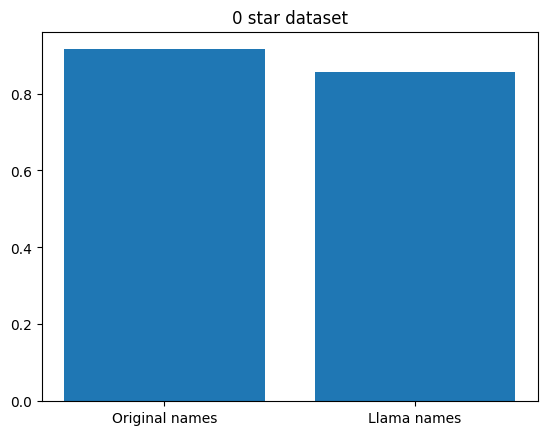

In [258]:
from matplotlib import pyplot as plt
plt.bar(['Original names', 'Llama names'],[df[df.name_type == "Original"].answer.mean(), df[df.name_type == "Llama"].answer.mean()])
plt.title("0 star dataset")
plt.show()

In [108]:
df[df.name_type == "Llama"].answer.count()

1648

In [179]:
from transformers import LlamaForCausalLM, CodeLlamaTokenizer, StoppingCriteria, StoppingCriteriaList
import pandas as pd
MODEL_NAME = "codellama/CodeLlama-7b-hf"
tokenizer= CodeLlamaTokenizer.from_pretrained(MODEL_NAME)

In [241]:
import numpy as np
def get_name_scores(x):
    scores = list(map(float, str(x.scores)[1:-1].split(',')))
    ids =  list(map(int, str(x.ids)[1:-1].split(',')))
    name_ids_raw = list(map(int, str(x.tokenized_name)[4:-2].split(',')))
    name_ids = [i for i in name_ids_raw if tokenizer.decode([i]) != ""]
    for i in range(len(name_ids),len(ids)):
        if ids[i-len(name_ids):i] == name_ids:
            return np.mean(scores[i-len(name_ids):i])          

    return 0
        

In [242]:
get_name_scores(df.loc[9])

0

In [243]:
df['mean_name_scores'] = df.apply(get_name_scores,axis =1)

ValueError: could not convert string to float: 'a'

In [217]:
df.head(15)

,name_type,prompt,function_name,real,generated,answer,scores,ids,tokenized_name,mean_name_scores
0.0,Original,#!/usr/bin/env python3\n\nUNKNOWN = -1\n\ndef ...,read_val,return [read_row() for _ in range(read_val...,"return list(map(read_row, input().split()))\n",False,"[21.578125, 16.59375, 20.40625, 23.078125, 20....","[1678, 736, 1051, 29898, 1958, 29898, 949, 299...","[[1, 1303, 29918, 791]]",0
1.0,Llama,#!/usr/bin/env python3\n\nUNKNOWN = -1\n\ndef ...,get_input,return [read_row() for _ in range(get_inpu...,"return list(map(read_row, input().split()))\n",False,"[21.96875, 15.9453125, 17.90625, 23.015625, 19...","[1678, 736, 1051, 29898, 1958, 29898, 949, 299...","[[1, 679, 29918, 2080]]",0
2.0,Original,#!/usr/bin/env python3\n\nUNKNOWN = -1\n\ndef ...,read_val,for t in range(read_val()):,def main():\n,False,"[18.25, 15.078125, 21.296875, 22.421875]","[1753, 1667, 7295, 13]","[[1, 1303, 29918, 791]]",0
3.0,Llama,#!/usr/bin/env python3\n\nUNKNOWN = -1\n\ndef ...,get_input,for t in range(get_input()):,def main():\n,False,"[18.109375, 14.296875, 20.375, 22.515625]","[1753, 1667, 7295, 13]","[[1, 679, 29918, 2080]]",0
4.0,Original,#!/usr/bin/env python3\n\nUNKNOWN = -1\n\ndef ...,read_row,return [read_row() for _ in range(read_val...,n = read_val()\n,False,"[21.59375, 15.4765625, 18.53125, 20.234375, 23...","[1678, 302, 353, 1303, 29918, 791, 580, 13]","[[1, 1303, 29918, 798]]",0
5.0,Llama,#!/usr/bin/env python3\n\nUNKNOWN = -1\n\ndef ...,read_row,return [read_row() for _ in range(get_inpu...,"return list(map(read_row, range(get_input()...",False,"[21.875, 15.3515625, 17.421875, 22.78125, 19.3...","[1678, 736, 1051, 29898, 1958, 29898, 949, 299...","[[1, 1303, 29918, 798]]",0
6.0,Original,#!/usr/bin/env python3\n\nUNKNOWN = -1\n\ndef ...,read_grid,print(compute_max_path_sum(read_grid())),grid = read_grid()\n,True,"[22.1875, 16.6875, 21.078125, 20.46875, 23.468...","[1678, 6856, 353, 1303, 29918, 7720, 580, 13]","[[1, 1303, 29918, 7720]]",0
7.0,Llama,#!/usr/bin/env python3\n\nUNKNOWN = -1\n\ndef ...,get_rows,print(loops(get_rows())),grid = get_rows()\n,True,"[21.875, 15.7734375, 20.75, 20.328125, 22.2343...","[1678, 6856, 353, 679, 29918, 5727, 580, 13]","[[1, 679, 29918, 5727]]",0
8.0,Original,#!/usr/bin/env python3\n\nUNKNOWN = -1\n\ndef ...,make_blank_row,return [make_blank_row(i) for i in range(1...,return [make_blank_row(n) for _ in range(n)]\n,True,"[22.25, 18.03125, 20.171875, 19.734375, 23.953...","[1678, 736, 518, 5675, 29918, 19465, 29918, 79...","[[1, 1207, 29918, 19465, 29918, 798]]",0
9.0,Llama,#!/usr/bin/env python3\n\nUNKNOWN = -1\n\ndef ...,double_list,"return [double_list(i) for i in range(1, n...",return [double_list(n) for _ in range(n)]\n,True,"[22.203125, 16.296875, 18.28125, 16.65625, 22....","[1678, 736, 518, 8896, 29918, 1761, 29898, 298...","[[1, 3765, 29918, 1761]]",0


In [47]:
print(df.loc[4].prompt)

#!/usr/bin/env python3

UNKNOWN = -1

def read_val():
    return int(input())






In [56]:
small_data = pd.read_csv('/home/sasha/effective-inference/clean_naming/small_data.csv', index_col = 0)

In [63]:
df.function_name.value_counts()

function_name
dfs                             6
compute_dynamics                3
__init__                        3
get_queryset                    2
read_val                        2
get_input                       2
read_row                        2
get_parent_game                 2
get_parent                      2
get_rows                        1
read_grid                       1
double_list                     1
make_blank_row                  1
loops                           1
compute_max_path_sum            1
make_blank_grid                 1
create_blank_rows               1
has_object_permission           1
dispatch                        1
descr_builtinfunction__new__    1
wrap_function                   1
descr_function_repr             1
__repr__                        1
Name: count, dtype: int64

In [73]:
small_data[:20][['target_function','count']]

,target_function,count
0,read_val,2
1,read_row,1
2,read_grid,1
3,make_blank_row,1
4,make_blank_grid,1
5,compute_max_path_sum,1
6,dfs,4
7,get_parent_game,2
8,get_queryset,1
9,dispatch,1


In [110]:
all_data = pd.read_csv('/home/sasha/effective-inference/clean_naming/next_line_all_data.csv', index_col = 0)

In [112]:
all_data

,name_type,prompt,function_name,real,generated,answer,scores,ids,tokenised_name,line_ids,ids_prompt,probs,name_probs,nonname_probs,mean_name_probs,mean_scores,name_scores,mean_name_scores
0,Original,"def str(val):\n """"""Convert float to string,...",str,return colnum2name(x) + str(y),return colnum2name(x) + str(y),True,"[24.109375, 18.203125, 19.09375, 22.8125, 25.2...","[1678, 736, 784, 1949, 29906, 978, 29898, 2991...",[851],"[1678, 736, 784, 1949, 29906, 978, 29898, 2991...","[1, 32007, 822, 851, 29898, 791, 1125, 13, 167...","[1.824138171242773e-13, 8.889663149602711e-06,...",[5.6465919442416634e-06],"[1.824138171242773e-13, 8.889663149602711e-06,...",5.646592e-06,20.658594,[18.234375],18.234375
1,GPT generated,"def locale_aware_float_to_string(val):\n """"...",locale_aware_float_to_string,return convert_column_number_to_name(x) + ...,assert y > 0,False,"[23.84375, 18.15625, 19.921875, 19.28125, 23.5...","[1678, 4974, 343, 1405, 29871, 29900, 13, 1678...","[15068, 29918, 28327, 29918, 7411, 29918, 517,...","[1678, 4974, 343, 1405, 29871, 29900]","[1, 32007, 822, 15068, 29918, 28327, 29918, 74...","[1.694665187259442e-13, 8.523251381120645e-06,...","[4.0546456148149446e-05, 6.608235594285361e-07...","[1.694665187259442e-13, 8.523251381120645e-06,...",4.615687e-05,21.343750,"[24.921875, 25.5]",25.210938
2,Numerical,"def 0(val):\n """"""Convert float to string, t...",0,return 1(x) + 0(y),"return ""%s%d"" % (1(x), y)",False,"[23.171875, 18.359375, 17.328125, 20.46875, 20...","[1678, 736, 11860, 29879, 29995, 29881, 29908,...","[29871, 29900]","[1678, 736, 11860, 29879, 29995, 29881, 29908,...","[1, 32007, 822, 29871, 29900, 29898, 791, 1125...","[1.8027221967802098e-13, 7.426019237755099e-06...","[8.357615399745555e-08, 0.04009966179728508, 2...","[1.8027221967802098e-13, 7.426019237755099e-06...",4.455834e-03,19.989062,[16.84375],16.843750
3,Translit,"def stroka(val):\n """"""Convert float to stri...",stroka,return kolonka_v_imya(x) + stroka(y),return kolonka_v_imya(x) + str(y),False,"[23.46875, 17.484375, 17.6875, 23.375, 25.0, 2...","[1678, 736, 14276, 265, 1335, 29918, 29894, 29...","[23351, 1335]","[1678, 736, 14276, 265, 1335, 29918, 29894, 29...","[1, 32007, 822, 23351, 1335, 29898, 791, 1125,...","[2.0253114777716436e-13, 9.92044442682527e-06,...","[6.9284660639823414e-06, 1.174421186078689e-06...","[2.0253114777716436e-13, 9.92044442682527e-06,...",2.706545e-06,21.708594,[25.0],25.000000
4,Original,"def str(val):\n """"""Convert float to string,...",colnum2name,return colnum2name(x) + str(y),return colnum2name(x) + str(y),True,"[24.109375, 18.203125, 19.09375, 22.8125, 25.2...","[1678, 736, 784, 1949, 29906, 978, 29898, 2991...","[784, 1949, 29906, 978]","[1678, 736, 784, 1949, 29906, 978, 29898, 2991...","[1, 32007, 822, 851, 29898, 791, 1125, 13, 167...","[1.824138171242773e-13, 8.889663149602711e-06,...","[1.7310953808191698e-06, 1.950041479403808e-07...","[1.824138171242773e-13, 8.889663149602711e-06,...",1.822797e-05,20.658594,"[19.09375, 22.8125, 25.25, 25.40625, 16.09375,...",21.286458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3703,Translit,"def peremeshannyj(seq):\n ""Return a randoml...",sluchajnaya_golovolomka,def sluchajnaya_golovolomka(N=17):,def vvedi_golovolomku(values):,False,"[15.9453125, 11.1875, 13.796875, 14.4453125, 1...","[1753, 325, 1490, 29875, 29918, 29887, 324, 58...","[2243, 987, 21552, 9010, 29918, 29887, 324, 58...","[1753, 325, 1490, 29875, 29918, 29887, 324, 58...","[1, 32007, 822, 639, 331, 12094, 14763, 29926,...","[1.8928885152022512e-13, 8.651123607705813e-06...","[7.060789286583713e-09, 2.0414207213548252e-08...","[1.8928885152022512e-13, 8.651123607705813e-06...",4.955767e-05,16.753906,"[17.453125, 14.71875, 20.703125, 18.5625, 18.7...",18.507812
3704,Original,"def shuffled(seq):\n ""Return a randomly shu...",random_puzzle,return random_puzzle(N) ## Give up and mak...,return random_puzzle(N) ## Give up and make...,True,"[20.578125, 22.59375, 19.437